## The Coupling Layer


The coupling layer is the heart of flow networks in that it allows for non-linear transformations that are still trivially invertible. With the help of a binary mask it takes half of the dimensions of its input. It then uses a regular artificial neural network to compute coupling parameters to transform the other half of input dimensions. That last transformation is usually trivial, e.g. addition or scaling to ensure simple inversion. The first half of input dimensions is then concatenated with that transformed second half and returned as output. It is important to realize, that the layer is trivially invertible, because the first half of the output can be fed through the regular neural network to obtain the very same coupling parameters that were computed in the forward operation. 

Some useful tips for this layer include:
- Ensure that the mask and the coupling layer receive the same axes and shape during construction.
- Choose a model to compute the coupling parameters whose output shape is the same as the input shape. 
- The model for computing coupling parameters should integrate dimensions along the same axes as the mask and coupling layer. That is, if mask and and coupling layer act on a single axis, e.g. the channel axis, then a  dense layer is suited for computing coupling paramters. If a Conv2D layer is used to compute coupling parameters, then mask and coupling layer should act on the same three (2 spatial, one channel) axes as that Conv2D layer.

*Documentation: Search the [modelling page](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html) for Coupling, AdditiveCoupling and AffineCoupling, Mask, masks.Heaviside and masks.CheckerBoard.*

In [7]:
import numpy as np, matplotlib.pyplot as plt
from gyoza.modelling import masks as gmm, flow_layers as mfl
import tensorflow as tf

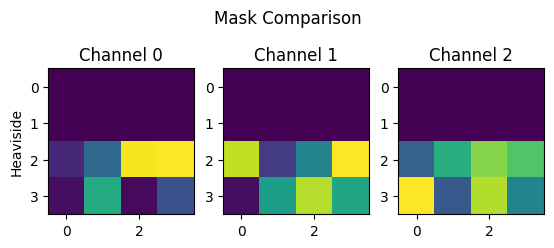

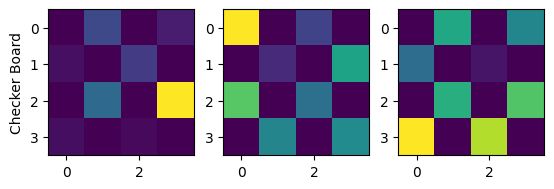

In [5]:
# Configuration
instance_count = 100; width = 4; height = 4; channel_count = 3
shape = [instance_count, width, height, channel_count]
dimensionality = np.prod(shape[1:])
X = np.random.normal(loc=3, scale=5, size=shape)
Y = X**2 + 3*X - 1

# Set up a mask to select half of the dimensions
heaviside_mask = gmm.Heaviside(axes=[1,2,3], shape=[width,height, channel_count])
checker_board_mask = gmm.CheckerBoard(axes=[1,2,3], shape=[width,height, channel_count]) # Alternative to Heaviside

# Plot
Y_hat = np.abs(heaviside_mask(X)) # Absolute value is simply for visualization
plt.figure(); plt.suptitle('Mask Comparison'); plt.subplot(2,3,1); plt.ylabel('Heaviside'); plt.title('Channel 0'); plt.imshow(Y_hat[0,:,:,0]); plt.subplot(2,3,2); plt.title('Channel 1'); plt.imshow(Y_hat[0,:,:,1]); plt.subplot(2,3,3); plt.title('Channel 2'); plt.imshow(Y_hat[0,:,:,2]); plt.show()
Y_hat = np.abs(checker_board_mask(X))
plt.subplot(2,3,4); plt.ylabel('Checker Board'); plt.imshow(Y_hat[0,:,:,0]); plt.subplot(2,3,5); plt.imshow(Y_hat[0,:,:,1]); plt.subplot(2,3,6); plt.imshow(Y_hat[0,:,:,2]); plt.show()


In [8]:
# Set up a regular artificial neural network to compute coupling parameters
compute_coupling_parameters = tf.keras.layers.Conv2D(filters=channel_count, kernel_size=(3,3), padding='same')

# Coupling
coupling = mfl.AdditiveCoupling(axes=[1,2,3], shape=[width, height, channel_count], compute_coupling_parameters=compute_coupling_parameters, mask=checker_board_mask)

# Print
print("The input to coupling has shape (instance count, width, height, channel count): ", X.shape)
Y_hat = coupling(X)
print("The output of coupling has shape  (instance count, width, height, channel count): ", Y_hat.shape)

The input to coupling has shape (instance count, width, height, channel count):  (100, 4, 4, 3)
The output of coupling has shape  (instance count, width, height, channel count):  (100, 4, 4, 3)


**Semi-Coupling:** Coupling layers can be used in succession, if they are interleaved with permutation layers. Since a coupling layer couples one half of dimensions with the other half, it performs semi-coupling. To ensure that all dimensions are transformed, it makes sense to permute them between coupling layers. A simple permutation is performed by the Shuffle layer which flattens its input along the provided axes, shuffles it (deterministically) and restores the original shape. *Documentation: Search the [modelling page](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html) for Permutation, Shuffle.*

**Complete Coupling:** In order to achieve coupling across all dimensions (instead of half of them) it makes sense to combine two coupling layers. The first coupling layer is set up as above, followed by a permutation layer that swops dimensions. Thereafter a second coupling layer is used and finally a permutation layer restores the original ordering of dimensions. Some useful tips for this form of coupling include:
- The permutation layer should be matched with the mask of the coupling layer. That is, a Heaviside mask (which selects the second half of dimensions after flattening) should be paired with a Heaside permutation layer. Similarly, a checkerboard mask (which selects every other dimension after flattening) shall be paired with a checkerboard permutation layer. 
- Permutation layers shall match the mask and coupling layers according to the axes and corresponding shape along those axes when processing the input.
- The first and second coupling layers should combine the two halves of dimensions in a similar way, e.g. both being additive or both being affine coupling layers.
- The first and second permutation layers shall be of the same type, e.g. both be Heaviside or both be checkerboard.

*Documentation: Search the [modelling page](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html) for Permutation, Heaviside and Checkerboard.*

In [9]:
# Permutation
shuffle_permute = mfl.Shuffle(axes=[1,2,3], shape=[width,height,channel_count])
heaviside_permute = mfl.Heaviside(axes=[1,2,3], shape=[width,height,channel_count])
checkerboard_permute = mfl.CheckerBoard(axes=[1,2,3], shape=[width,height,channel_count])

Y_hat = shuffle_permute(X)
Y_hat = heaviside_permute(X)
Y_hat = checkerboard_permute(X)

# Print
print("The input to permutation has shape (instance count, width, height, channel count): ", X.shape)
Y_hat = shuffle_permute(X)
print("The output of permutation has shape  (instance count, width, height, channel count): ", Y_hat.shape)

The input to permutation has shape (instance count, width, height, channel count):  (100, 4, 4, 3)
The output of permutation has shape  (instance count, width, height, channel count):  (100, 4, 4, 3)


In [10]:
# Second coupling layer
compute_coupling_parameters_2 = tf.keras.layers.Conv2D(filters=channel_count, kernel_size=(3,3), padding='same')
coupling_2 = mfl.AdditiveCoupling(axes=[1,2,3], shape=[width, height, channel_count], compute_coupling_parameters=compute_coupling_parameters_2, mask=checker_board_mask)

## Data Synthesis

In [ ]:
# Set up the raw manifold function
manifold_name = 'f_2'
manifold_function = lambda S: gum.rotate(xs=np.arcsinh(S), ys=np.sign(np.arcsinh(S)) * np.cosh(np.arcsinh(S)) - np.sign(S), theta=1.2*np.pi/2.0)

# Generate points along a line
M = 2**13; N = 2 # Instance count, dimension count
reset_random_number_generators(seed=12) # Reproducability
S = np.random.normal(loc=0, scale=1, size=[M])

# Generate a dataset
noise_standard_deviation = [0.1, 0.1]
Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, Factor count]
batch_size = 2**9
target_correlations = [0.0, 0.975]
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size = batch_size, target_correlations=target_correlations)

# Plot pairs of instances
Z_ab, Y_ab  = next(iterator)
plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function=manifold_function, manifold_name=manifold_name)
plot_instance_pairs_2(Z_ab=Z_ab)

In [ ]:
# Create network
def create_network(stage_count: int):

    network = mfl.SupervisedFactorModel(layers=[], dimensions_per_factor=[1,1], sigma=1.0) # One dimension for the residual factor (index 0) and one for the manifold proximity (index 1)
    for i in range(stage_count):
        network.add(mfl.AdditiveCoupling(axes=[1], 
                                        shape=[N], 
                                        compute_coupling_parameters=msl.BasicFullyConnectedNet(latent_dimension_count=4*N, output_dimension_count=N, depth=3), 
                                        mask=gmm.CheckerBoard(axes=[1], shape=[N])))
        network.add(mfl.Heaviside(axes=[1], shape=[N]))

        network.add(mfl.AdditiveCoupling(axes=[1], 
                                        shape=[N], 
                                        compute_coupling_parameters=msl.BasicFullyConnectedNet(latent_dimension_count=4*N, output_dimension_count=N, depth=3), 
                                        mask=gmm.CheckerBoard(axes=[1], shape=[N])))
        network.add(mfl.Heaviside(axes=[1], shape=[N]))

    return network

reset_random_number_generators(seed=2) # Reproducability
stage_count = 2
network = create_network(stage_count=stage_count)

# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name)


## Model Training

In [ ]:
# Calibrate network
learning_rate = 0.01
network.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate))
batch_size = M//8
epoch_count = 75
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=epoch_count, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

## Evaluation

In [ ]:
# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

In [ ]:
# Plot interactive tool
interact(plot_inverse_point, position=(-1.5,1.5,0.1), residual=(-1.5,1.5,0.1), S=fixed(np.random.choice(a=S, size=[128], replace=False)), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name))

In [ ]:
Z_tilde_a = network(Z_ab[:,0,:])[:,np.newaxis,:]
Z_tilde_b = network(Z_ab[:,1,:])[:,np.newaxis,:]
Z_tilde_ab = tf.concat([Z_tilde_a, Z_tilde_b], axis=1)
plot_instance_pairs_2(Z_ab=Z_tilde_ab)